# Imports

## Import gen lib

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow
import matplotlib.pyplot as plt
import keras_tuner as kt

2022-06-15 16:03:11.382729: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## imports sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## imports keras

In [3]:
from keras.models import Sequential
from keras.layers import Dense

## Import data

In [4]:
path_dataset = '../data/housepricedata.csv'

In [5]:
df = pd.read_csv(path_dataset)

In [6]:
df

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,AboveMedianPrice
0,8450,7,5,856,2,1,3,8,0,548,1
1,9600,6,8,1262,2,0,3,6,1,460,1
2,11250,7,5,920,2,1,3,6,1,608,1
3,9550,7,5,756,1,0,3,7,1,642,0
4,14260,8,5,1145,2,1,4,9,1,836,1
...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,6,5,953,2,1,3,7,1,460,1
1456,13175,6,6,1542,2,0,3,7,2,500,1
1457,9042,7,9,1152,2,0,4,9,2,252,1
1458,9717,5,6,1078,1,0,2,5,0,240,0


# Visu

In [7]:
df.AboveMedianPrice.value_counts()

0    732
1    728
Name: AboveMedianPrice, dtype: int64

# Set up dataset for RNN

## X and y

In [75]:
dataset = df.values
X = dataset[:,0:10]
y = dataset[:,10]

## train test split + validation set with validation

In [112]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train_scaled,y_train,stratify=y_train)

In [115]:
X_train.shape

(821, 10)

In [116]:
y_train.shape

(821,)

# Keras model

The first thing we have to do is to set up the architecture. Let’s first think about what kind of neural network architecture we want. Suppose we want this neural network:
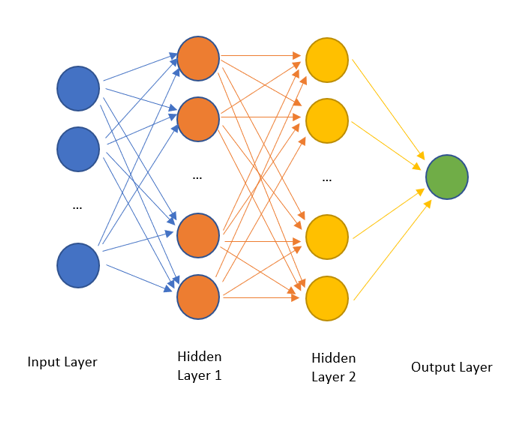
In words, we want to have these layers:

- Hidden layer 1: 12 neurons, ReLU activation
- Hidden layer 2: 16 neurons, ReLU activation
- Output Layer: 1 neuron, Sigmoid activation
    
Now, we need to describe this architecture to Keras. We will be using the Sequential model, which means that we merely need to describe the layers above in sequence.

In [120]:
model = keras.Sequential(
    [
        Dense(12,activation='relu',name='layer1',input_shape=(10,)),# pas besoin d'input sequentiel le réalise de manière automatique
        Dense(16,activation='relu',name='layer2'),
        Dense(1,activation='sigmoid',name='output_layer'),
    ]
)

In [121]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

In [128]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [129]:
history = model.fit(X_train,y_train,epochs=100,batch_size=24,validation_data=(X_valid,y_valid),verbose=1)

Epoch 1/100
35/35 [==============================] - 1s 9ms/step - loss: 0.5169 - accuracy: 0.8463 - val_loss: 0.3664 - val_accuracy: 0.8869
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2543 - accuracy: 0.8944 - val_loss: 0.3071 - val_accuracy: 0.8759
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2201 - accuracy: 0.9254 - val_loss: 0.3359 - val_accuracy: 0.8540
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2472 - accuracy: 0.9200 - val_loss: 0.3734 - val_accuracy: 0.8686
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2024 - accuracy: 0.9286 - val_loss: 0.4859 - val_accuracy: 0.8905
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.2222 - accuracy: 0.9039 - val_loss: 0.3755 - val_accuracy: 0.9051
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.2078 - accuracy: 0.9115 - val_loss: 0.3506 - val_accuracy: 0.8832
Epoch 8/100
3

In [130]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 12)                132       
_________________________________________________________________
layer2 (Dense)               (None, 16)                208       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 357
Trainable params: 357
Non-trainable params: 0
_________________________________________________________________


In [131]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

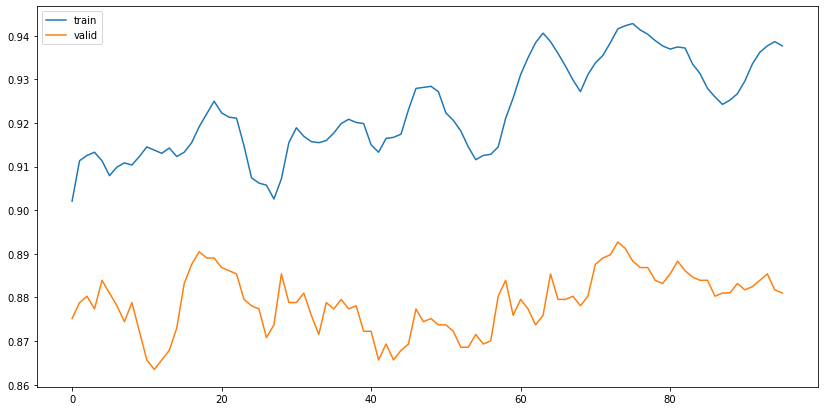

In [132]:
N=5
fig,ax = plt.subplots(figsize=(14,7))
acc_val = history.history['val_accuracy']
acc_val = np.convolve(acc_val, np.ones(N)/N, mode='valid') # rolling mean of N
acc_train = history.history['accuracy']
acc_train = np.convolve(acc_train, np.ones(N)/N, mode='valid')
ax.plot(acc_train,label='train')
ax.plot(acc_val,label='valid')
ax.legend()
plt.show()

In [133]:
pred  = model.predict(X_test_scaled)

In [134]:
pred[pred > 0.5] = 1
pred[pred < 0.5] = 0

In [135]:
accuracy_score(y_test,pred)

0.8876712328767123

### Compare with original compile and parameters

In [93]:
model = keras.Sequential(
    [
        Dense(12,activation='relu',name='layer1',input_shape=(10,)),
        Dense(16,activation='relu',name='layer2'),
        Dense(1,activation='sigmoid',name='output_layer'),
    ]
)

In [94]:
opt = keras.optimizers.SGD(learning_rate=0.0001,momentum=0.5)

In [95]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=100,batch_size=24,validation_data=(X_valid,y_valid),verbose=1)

Epoch 1/100
35/35 [==============================] - 1s 9ms/step - loss: 0.6823 - accuracy: 0.5354 - val_loss: 0.6748 - val_accuracy: 0.5620
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 0.6683 - accuracy: 0.5873 - val_loss: 0.6741 - val_accuracy: 0.5657
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.5776 - val_loss: 0.6733 - val_accuracy: 0.5693
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.5801 - val_loss: 0.6726 - val_accuracy: 0.5693
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 0.6766 - accuracy: 0.5576 - val_loss: 0.6719 - val_accuracy: 0.5766
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.5604 - val_loss: 0.6712 - val_accuracy: 0.5803
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.6685 - accuracy: 0.5731 - val_loss: 0.6704 - val_accuracy: 0.5839
Epoch 8/100
3

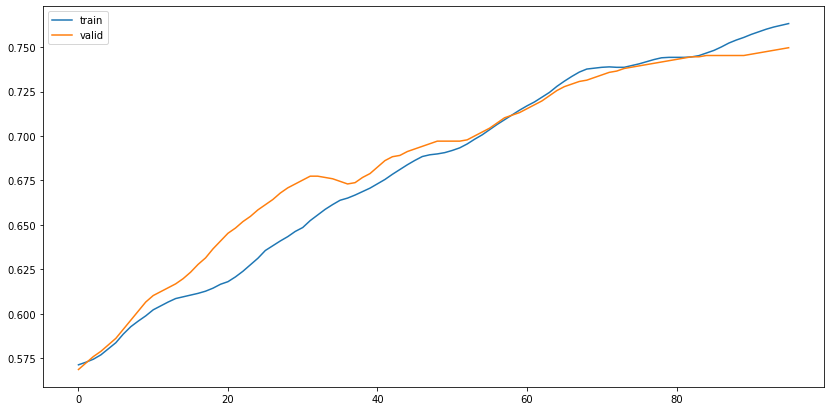

In [100]:
N=5
fig,ax = plt.subplots(figsize=(14,7))
acc_val = history.history['val_accuracy']
acc_val = np.convolve(acc_val, np.ones(N)/N, mode='valid') # rolling mean of N
acc_train = history.history['accuracy']
acc_train = np.convolve(acc_train, np.ones(N)/N, mode='valid')
ax.plot(acc_train,label='train')
ax.plot(acc_val,label='valid')
ax.legend()
plt.show()

### Keras tuner

In [164]:
def build_model(hp):
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10000,
    decay_rate=0.9)

    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model = keras.Sequential()
    model.add(keras.layers.Dense(
      hp.Choice('units', [4,8, 16, 32]),
      activation='relu',
    input_shape=(10,)))
    model.add(Dense(hp.Choice('units__', [16, 32]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [165]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    directory = '../models/tuner/',
    project_name = 'housing_price',
    max_trials=10)

In [166]:
tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))
best_model = tuner.get_best_models()[0]

Trial 8 Complete [00h 00m 03s]
val_accuracy: 0.8905109763145447

Best val_accuracy So Far: 0.9087591171264648
Total elapsed time: 00h 00m 24s
INFO:tensorflow:Oracle triggered exit


In [167]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
